In [ ]:
"""
Created on Jun 30 2021
@author: Neven Caplar
@contact: ncaplar@princeton.edu
"""

In [32]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

In [33]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [52]:
def create_mask(FFTTest_fiber_and_pixel_convolved_downsampled_40,semi=None):
    """!given the image, create a mask
        if semi is not specified, it gives the masks which span in all directions
        if semi is specified is masks towards only towards the region specified
        
    
    @param FFTTest_fiber_and_pixel_convolved_downsampled_40     science data stamp
    @param semi (+,-,l,r)                                       which region to uncover
     """    
    central_position=np.array(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40))
    central_position_int=np.round(central_position)
    central_position_int_x=int(central_position_int[0])
    central_position_int_y=int(central_position_int[1])

    size=len(FFTTest_fiber_and_pixel_convolved_downsampled_40)
    
    center_square=np.zeros((size,size))
    if size==20:
        cutsize=3
        small_cutsize=2
    if size>20:
        cutsize=6
        small_cutsize=4
    
    center_square[central_position_int_y-cutsize:+central_position_int_y+cutsize,central_position_int_x-cutsize:central_position_int_x+cutsize]=np.ones((2*cutsize,2*cutsize))
    # need to add l and r here
    horizontal_cross=np.zeros((size,size))
    horizontal_cross[central_position_int_y-cutsize:central_position_int_y+cutsize,0:size,]=np.ones((2*cutsize,size))
    horizontal_cross_full=horizontal_cross
    horizontal_cross=horizontal_cross-center_square



    vertical_cross=np.zeros((size,size))
    if semi is None:
        vertical_cross[0:size,central_position_int_x-cutsize:central_position_int_x+cutsize]=np.ones((size,2*cutsize))
        vertical_cross=vertical_cross-center_square
    if semi=='+':
        vertical_cross[central_position_int_y+cutsize:size,central_position_int_x-cutsize:central_position_int_x+cutsize]=np.ones((size-central_position_int_y-cutsize,2*cutsize))
    if semi=='-':
        vertical_cross[0:central_position_int_y+1-cutsize,central_position_int_x-cutsize:central_position_int_x+cutsize]=np.ones((central_position_int_y+1-cutsize,2*cutsize))
    vertical_cross_full=vertical_cross


    diagonal_cross=np.zeros((size,size))
    if semi is None:
        #print(central_position_int_y)
        #print(central_position_int_x)
        diagonal_cross[0:central_position_int_y-small_cutsize,0:central_position_int_x-small_cutsize]=np.ones((central_position_int_y-small_cutsize,central_position_int_x-small_cutsize))
        diagonal_cross[(central_position_int_y+small_cutsize):size,0:(central_position_int_x-small_cutsize)]=np.ones((size-(central_position_int_y+small_cutsize),(central_position_int_x-small_cutsize)))
        diagonal_cross[0:(central_position_int_y-small_cutsize),(central_position_int_x+small_cutsize):size]=np.ones(((central_position_int_y-small_cutsize),size-(central_position_int_x+small_cutsize)))
        diagonal_cross[(central_position_int_y+small_cutsize):size,(central_position_int_x+small_cutsize):size]=np.ones((size-(central_position_int_y+small_cutsize),size-(central_position_int_x+small_cutsize)))
    if semi=='+':
        diagonal_cross[(central_position_int_y+small_cutsize):size,0:(central_position_int_x-small_cutsize)]=np.ones((size-(central_position_int_y+small_cutsize),(central_position_int_x-small_cutsize)))
        diagonal_cross[(central_position_int_y+small_cutsize):size,(central_position_int_x+small_cutsize):size]=np.ones((size-(central_position_int_y+small_cutsize),size-(central_position_int_x+small_cutsize)))
    if semi=='-':
        diagonal_cross[0:central_position_int_y-small_cutsize,0:central_position_int_x-small_cutsize]=np.ones((central_position_int_y-small_cutsize,central_position_int_x-small_cutsize))
        diagonal_cross[0:(central_position_int_y-small_cutsize),(central_position_int_x+small_cutsize):size]=np.ones(((central_position_int_y-small_cutsize),size-(central_position_int_x+small_cutsize)))
    if semi=='r':
        diagonal_cross[(central_position_int_y+small_cutsize):size,(central_position_int_x+small_cutsize):size]=np.ones((size-(central_position_int_y+small_cutsize),size-(central_position_int_x+small_cutsize)))
        diagonal_cross[0:(central_position_int_y-small_cutsize),(central_position_int_x+small_cutsize):size]=np.ones(((central_position_int_y-small_cutsize),size-(central_position_int_x+small_cutsize)))
    if semi=='l':
        diagonal_cross[0:central_position_int_y-small_cutsize,0:central_position_int_x-small_cutsize]=np.ones((central_position_int_y-small_cutsize,central_position_int_x-small_cutsize))
        diagonal_cross[(central_position_int_y+small_cutsize):size,0:(central_position_int_x-small_cutsize)]=np.ones((size-(central_position_int_y+small_cutsize),(central_position_int_x-small_cutsize)))

    total_mask=np.zeros((size,size))
    if semi is None:
        total_mask=np.ones((size,size))
    if semi=='+':
        total_mask[(central_position_int_y):size,0:size]=np.ones((size-(central_position_int_y),size))
    if semi=='-':
        total_mask[:(central_position_int_y),0:size]=np.ones(((central_position_int_y),size))
    if semi=='r':
        total_mask[:(central_position_int_y),0:size]=np.ones(((central_position_int_y),size))  
    if semi=='l':
        total_mask[:(central_position_int_y),0:size]=np.ones(((central_position_int_y),size))   
        
    return [center_square,horizontal_cross,vertical_cross,diagonal_cross,total_mask]


def create_res_data(FFTTest_fiber_and_pixel_convolved_downsampled_40,mask=None,custom_cent=None,size_pixel=None):
    """!given the small science image, create radial profile in microns
    
    @param FFTTest_fiber_and_pixel_convolved_downsampled_40     science data stamps
    @param mask                                                 mask to cover science data [default: None]
    @param custom_cent                                          if None create new center using the function ``find_centroid_of_flux'' [default:None]
                                                                - otherwise pass a list/array/tuple with [x_center, y_center] in units of pixels 
                                                                (e.g., output of find_centroid_of_flux function )
    @param size_pixel                                           pixel size in the image, in microns [default:15, dithered=7.5, normal operation=15]
     """     
     
    xs_uniform=find_centroid_of_flux(np.ones(FFTTest_fiber_and_pixel_convolved_downsampled_40.shape))[0] 
    ys_uniform=find_centroid_of_flux(np.ones(FFTTest_fiber_and_pixel_convolved_downsampled_40.shape))[1]
    
    print('center of the uniform values in units of pixels is:' +str([xs_uniform,ys_uniform]))
    
    # changed in 0.25 
    if size_pixel is None:
        size_pixel=15

    image_shape=np.array(FFTTest_fiber_and_pixel_convolved_downsampled_40.shape)

    if mask is None:
        mask=np.ones((FFTTest_fiber_and_pixel_convolved_downsampled_40.shape[0],FFTTest_fiber_and_pixel_convolved_downsampled_40.shape[1]))
    
    if custom_cent is None:
        xs0=(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40,mask)[0]-xs_uniform)*size_pixel
        ys0=(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40,mask)[1]-ys_uniform)*size_pixel
        print('center deduced  (in respect to the center of image, units of microns) at:' +str([xs0,ys0]))
    else:
        xs0,ys0=(custom_cent[0]-xs_uniform)*size_pixel,(custom_cent[1]-xs_uniform)*size_pixel
        print('center specified (in respect to the center of image, units of pixels) at:' +str([xs0,ys0]))
            
    pointsx = np.linspace(-(int(image_shape[0]*size_pixel)-size_pixel)/2,(int(image_shape[0]*size_pixel)-size_pixel)/2,num=int(image_shape[0]))
    pointsy = np.linspace(-(int(image_shape[0]*size_pixel)-size_pixel)/2,(int(image_shape[0]*size_pixel)-size_pixel)/2,num=int(image_shape[0]))
    xs, ys = np.meshgrid(pointsx, pointsy)
    r0 = np.sqrt((xs-xs0)** 2 + (ys-ys0)** 2)
    

    
    distances=range(int(image_shape[0]/2*size_pixel*1.2))

    res_test_data=[]
    for r in distances:
        pixels_upper_limit=(mask*FFTTest_fiber_and_pixel_convolved_downsampled_40)[r0<(r+size_pixel)]
        pixels_lower_limit=(mask*FFTTest_fiber_and_pixel_convolved_downsampled_40)[r0<(r)]
        
        mask_upper_limit=mask[r0<(r+size_pixel)]
        mask_lower_limit=mask[r0<(r)]
        
        number_of_valid_pixels=np.sum(mask_upper_limit)-np.sum(mask_lower_limit)
        
        if number_of_valid_pixels==0:
            res_test_data.append(0)
        else:                  
            average_flux=(np.sum(pixels_upper_limit)-np.sum(pixels_lower_limit))/number_of_valid_pixels
            res_test_data.append(average_flux)        

    return distances,res_test_data 

def find_centroid_of_flux(image,mask=None):
    """
    function giving the tuple of the position of weighted average of the flux in a square image
    
    @input image    poststamp image for which to find center
    @input mask     mask, has to be the same size as the image
    
    returns tuple with x and y center, in units of pixels
    """
    if mask is None:
        mask=np.ones(image.shape)
    
    x_center=[]
    y_center=[]
    
    # if there are nan values (most likely cosmics), replace them with max value in the rest of the image
    # careful, this can seriously skew the results if not used for this purpose
    max_value_image=np.max(image[~np.isnan(image)])
    image[np.isnan(image)]=max_value_image

    I_x=[]
    for i in range(len(image)):
        I_x.append([i,np.mean(image[:,i]*mask[:,i])])

    I_x=np.array(I_x)

    I_y=[]
    for i in range(len(image)):
        I_y.append([i,np.mean(image[i]*mask[i])])

    I_y=np.array(I_y)


    x_center=(np.sum(I_x[:,0]*I_x[:,1])/np.sum(I_x[:,1]))
    y_center=(np.sum(I_y[:,0]*I_y[:,1])/np.sum(I_y[:,1]))

    return(x_center,y_center)

In [47]:
# creating a fake image, just as an example
x, y = np.meshgrid(np.linspace(-5,5,50), np.linspace(-5,5,50))
dst = np.sqrt(x*x+y*y)
  
# Intializing sigma and muu
sigma = 1
muu = 0.000
  
# Calculating Gaussian array
gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) ) * 10000

Hg_fake_continum=np.zeros((50,50))
for i in range(Hg_fake_continum.shape[0]):
    Hg_fake_continum[i]=np.sum(gauss,axis=1)*0.02

random_noise=np.random.normal(0, 10, size=(50, 50))

full_test_image=gauss+random_noise+Hg_fake_continum

Text(0.5, 1.0, 'flux outside along the diagonal')

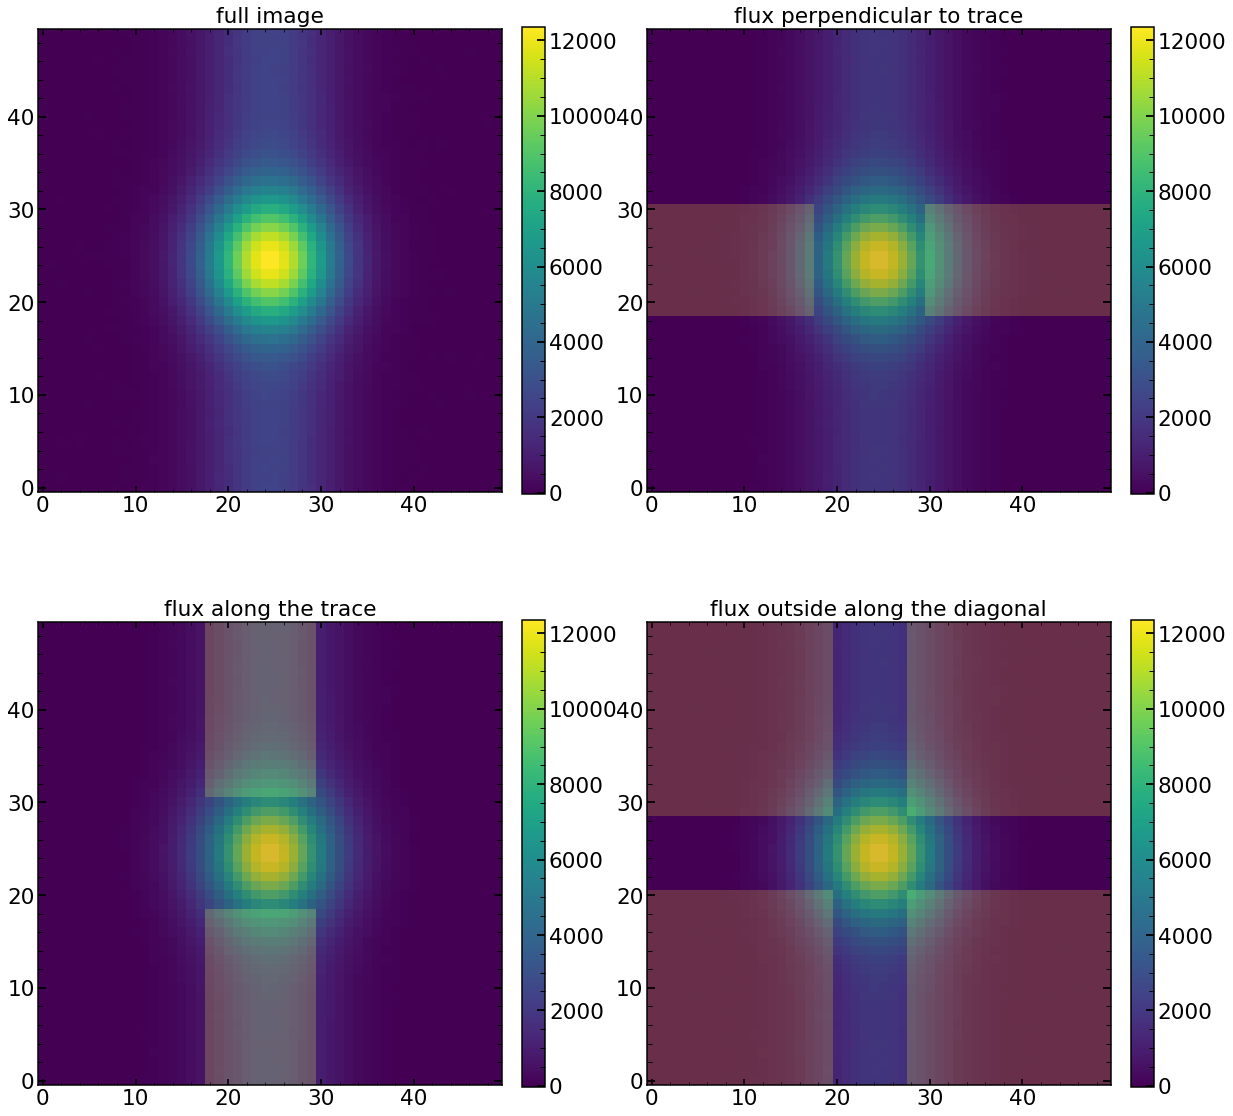

In [68]:
# image showing what do different masks do
# it is possible to do masks that only cover certain regions, but it probably not needed

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(full_test_image)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('full image')

plt.subplot(222)
plt.imshow(full_test_image)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(create_mask(full_test_image)[1],alpha=0.2)
plt.title('flux perpendicular to trace')

plt.subplot(223)
plt.imshow(full_test_image)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(create_mask(full_test_image)[2],alpha=0.2)
plt.title('flux along the trace')

plt.subplot(224)
plt.imshow(full_test_image)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(create_mask(full_test_image)[3],alpha=0.2)
plt.title('flux outside along the diagonal')



In [71]:
result_from_data=create_res_data(full_test_image,mask=None,custom_cent=None,size_pixel=15)

# you need to specify the center of the image, deduced from the full image, without applying the mask
# specify size of pixel in microns (15)
result_from_data_perpendicular=create_res_data(full_test_image,mask=create_mask(full_test_image)[1],custom_cent=find_centroid_of_flux(full_test_image),size_pixel=15)
result_from_data_along=create_res_data(full_test_image,mask=create_mask(full_test_image)[2],custom_cent=find_centroid_of_flux(full_test_image),size_pixel=15)
result_from_data_diagonal=create_res_data(full_test_image,mask=create_mask(full_test_image)[3],custom_cent=find_centroid_of_flux(full_test_image),size_pixel=15)

center of the uniform values in units of pixels is:[24.5, 24.5]
center deduced  (in respect to the center of image, units of microns) at:[-0.024068169534547934, 0.047488714688785905]
center of the uniform values in units of pixels is:[24.5, 24.5]
center specified (in respect to the center of image, units of pixels) at:[-0.024068169534547934, 0.047488714688785905]
center of the uniform values in units of pixels is:[24.5, 24.5]
center specified (in respect to the center of image, units of pixels) at:[-0.024068169534547934, 0.047488714688785905]
center of the uniform values in units of pixels is:[24.5, 24.5]
center specified (in respect to the center of image, units of pixels) at:[-0.024068169534547934, 0.047488714688785905]


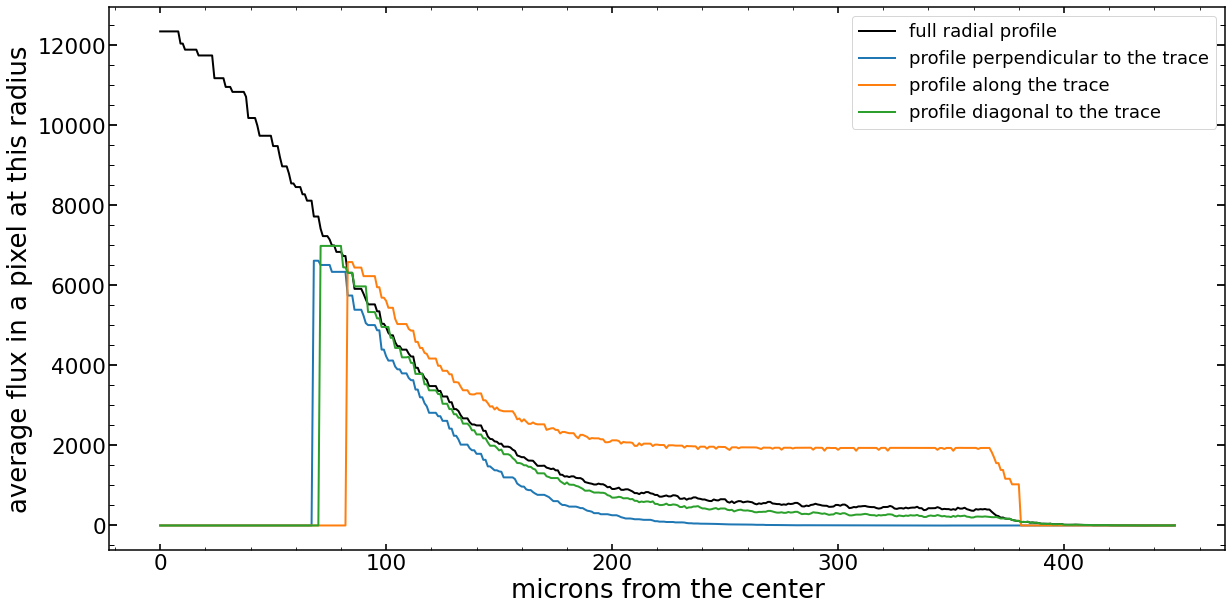

In [74]:
plt.figure(figsize=(20,10))
plt.plot(result_from_data[0],result_from_data[1],lw=2,color='black', label='full radial profile')
plt.plot(result_from_data_diagonal[0],result_from_data_perpendicular[1],lw=2, label='profile perpendicular to the trace')
plt.plot(result_from_data_diagonal[0],result_from_data_along[1],lw=2, label='profile along the trace')

plt.plot(result_from_data_diagonal[0],result_from_data_diagonal[1],lw=2, label='profile diagonal to the trace')
plt.xlabel('microns from the center')
plt.ylabel('average flux in a pixel at this radius')

plt.legend()